# 0. Modules imports

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import random as rd
import math

# 1. Main functions and objects definition

In [21]:
def periodogram(values, sampling_frequency):    
    N=np.size(values)
    #Computation of the FFT
    X=np.fft.fft(values)
    X=np.fft.fftshift(X)
    Gammax=(np.abs(X)**2)/N
    # Computation the frequency vector
    f=np.fft.fftfreq(N, d=1/sampling_frequency)
    f=np.fft.fftshift(f)

    symetric_Gammax = Gammax
    symetric_f = f
    Gammax = symetric_Gammax[len(symetric_Gammax)//2:]
    normalised_Gammax = Gammax/np.max(Gammax)
    f = symetric_f[len(symetric_f)//2 :]
    
    return symetric_Gammax, symetric_f, Gammax, normalised_Gammax, f

Codes to find the emission band

In [22]:
def find_f_min(f, Gammax, epsilon):
    i = 0

    while Gammax[i]<epsilon and i<len(f)-1:
        i += 1
    
    return i, f[i]


In [23]:
def find_f_max(f,Gammax, epsilon):
    i = len(f) - 1
    
    while Gammax[i]<epsilon and i>0:
        i = i - 1
    
    return i, f[i]

DSP energy computation

In [24]:
#Integration of Gammax with respect to f using rectangles
def compute_DSP_energy(f, Gammax):
    energy = 0
    for i in range(1, len(f)):
        energy += Gammax[i]*(f[i] - f[i-1]) 
    return energy
    


Object wrappers

In [25]:
class Data():
    def __init__(self, index, values, sampling_frequency,  database_name = '', epsilon = 0.1):
        self.index = index
        self.database_name = database_name

        #Forbidden info in the context of the project
        #self.class_index = values[0]

        self.epsilon = epsilon

        self.values = np.array(values[1:])

        self.symetric_Gammax, self.symetric_f, self.Gammax, self.normalised_Gammax, self.f = periodogram(self.values,sampling_frequency)

        self.f_min_index, self.f_min = find_f_min(self.f, self.normalised_Gammax, self.epsilon)
        self.f_max_index, self.f_max = find_f_max(self.f, self.normalised_Gammax, self.epsilon)

        self.delta_f = self.f_max - self.f_min

        self.energy = compute_DSP_energy(self.f, self.Gammax)
        self.normalised_energy = compute_DSP_energy(self.f, self.normalised_Gammax)

        

In [26]:
class Database():
    def __init__(self, name, datas):
        self.name = name
        self.datas = datas

        for data in self.datas:
            data.database_name = self.name

Plot utils

In [27]:
# This function is meant to be used in a larger plot function
def plot_custom(x, y, axis = None, xscale = None, yscale = None, title = None, xlabel = None, ylabel = None):

    
    if axis == None:
        plt.plot(x, y)

        if xscale != None:
            plt.xscale = (xscale)

        if yscale != None:
            plt.yscale = (yscale)
        
        if title != None:
            plt.title(title)
        
        if xlabel != None:
            plt.xlabel(xlabel)

        if ylabel != None:
            plt.ylabel(ylabel)


    else:
        axis.plot(x, y)

        if xscale != None:
            axis.set_xscale = (xscale)

        if yscale != None:
            axis.set_yscale = (yscale)

        if title != None:
            axis.title(title)
        
        if xlabel != None:
            axis.xlabel(xlabel)

        if ylabel != None:
            axis.ylabel(ylabel)

        return axis


In [28]:
# This function is meant to be used in a larger plot function
def plot_dsp_emission_band(data, axis = None, normalise = False):
    emission_band = np.zeros(len(data.f))

    if data.f_max_index == len(data.f)-1:
        include = 0
    
    else:
        include = 1

    if normalise:
        emission_value = 1
    
    else:
        emission_value = np.max(data.Gammax)

    for i in range(data.f_min_index, data.f_max_index + include):
        emission_band[i] = emission_value
    
    if axis != None:
        return plot_custom(x = data.f,
                                y = emission_band,
                                axis = axis,
                            )
    
    plot_custom(x = data.f,
                    y = emission_band,
                    )
                   

In [29]:
def plot_DSP(data, axis = None, normalise = False, symetric = False):
    if symetric:
        x = data.symetric_f
        y = data.symetric_Gammax

    elif normalise:
        x = data.f
        y = data.normalised_Gammax
    
    else:
        x = data.f
        y = data.Gammax

    if axis != None:
        return plot_custom(x = data.f,
                                y = y,
                                axis = axis,
                            )
    
    plot_custom(x = data.f,
                    y = y,
                    )
                            

# 3. Data loading

In [30]:
def load_database(database_path, sampling_frequency, epsilon):
    datas = []

    with open(database_path, 'r') as file:
        data_index = 0
        for raw_data in file:
            raw_data_line = raw_data.strip('\n').split(' ')
            data_values = []
            for raw_value in raw_data_line:
                if len(raw_value)!=0:
                    data_values.append(float(raw_value))

            datas.append(Data(data_index, data_values, sampling_frequency = sampling_frequency, epsilon = epsilon))
            data_index += 1
        
    name = database_path.strip('.txt').split('/')[-1]
    return Database(name, datas)

In [31]:
train_database_path = '/teamspace/studios/this_studio/Données/FordB_TRAIN.txt'
test_database_path = '/teamspace/studios/this_studio/Données/FordB_TEST.txt'

sampling_frequency = 46000
epsilon = 0.035

In [32]:
train_database = load_database(train_database_path, sampling_frequency, epsilon)
test_database = load_database(test_database_path, sampling_frequency, epsilon)

# 3. Plots and tests

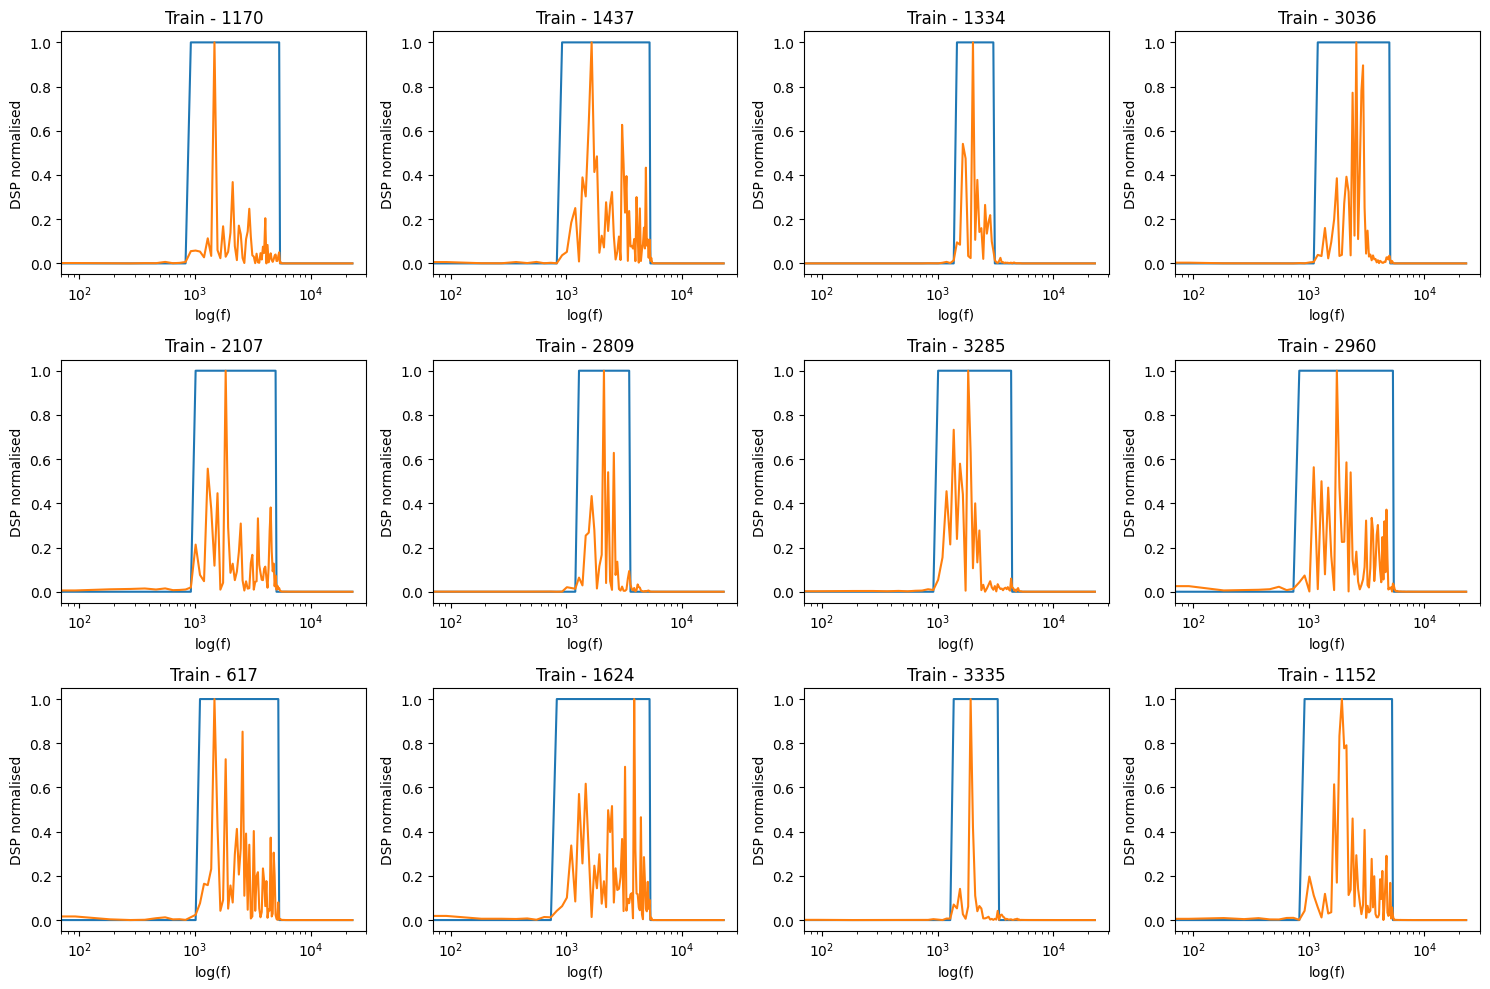

In [33]:
sample_size = 12
train_sample = rd.sample(train_database.datas, sample_size)


cols = math.ceil(math.sqrt(sample_size))  # Try to make the figure roughly square
rows = math.ceil(sample_size / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array for easy iteration (only if more than 1 row/column)
axes = axes.flatten()

for data_index, data in enumerate(train_sample):
    plot_dsp_emission_band(data, normalise = True, axis = axes[data_index])
    plot_DSP(data, normalise = True, axis = axes[data_index])
    axes[data_index].set_title(f'Train - {data.index}')
    axes[data_index].set_xscale('log')
    axes[data_index].set_xlabel('log(f)')
    axes[data_index].set_ylabel('DSP normalised')

# Hide unused subplots if any
for i in range(sample_size, rows * cols):
    fig.delaxes(axes[i])  # Deletes the extra subplots

plt.tight_layout()
plt.show()


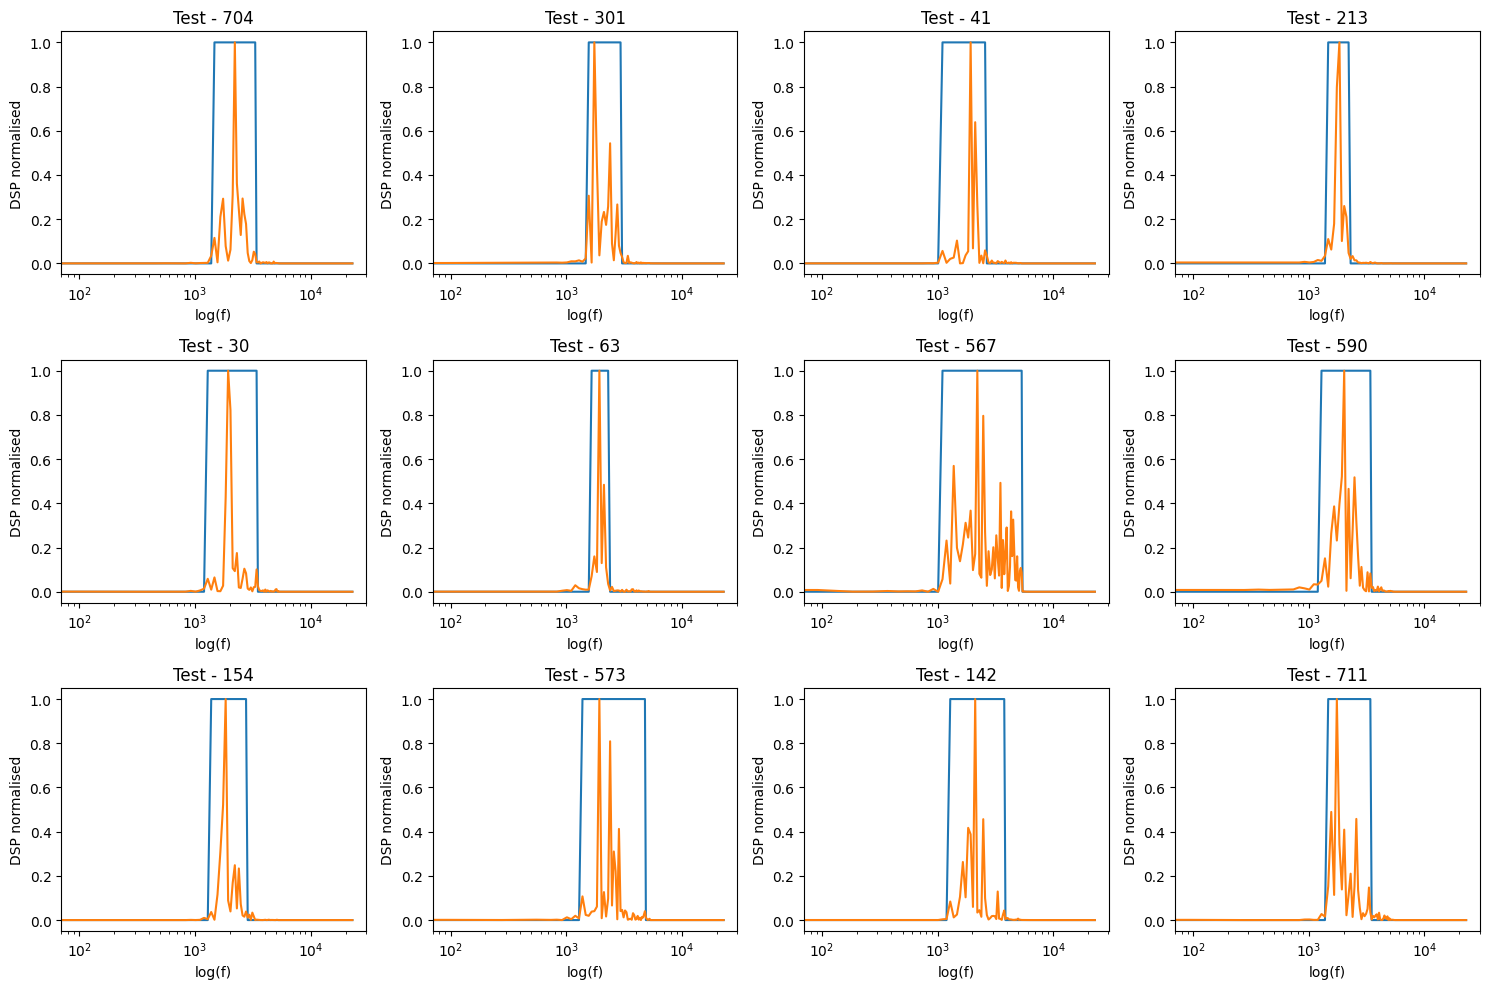

In [34]:
sample_size = 12
test_sample = rd.sample(test_database.datas, sample_size)


cols = math.ceil(math.sqrt(sample_size))  # Try to make the figure roughly square
rows = math.ceil(sample_size / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array for easy iteration (only if more than 1 row/column)
axes = axes.flatten()

for data_index, data in enumerate(test_sample):
    plot_dsp_emission_band(data, normalise = True, axis = axes[data_index])
    plot_DSP(data, normalise = True, axis = axes[data_index])
    axes[data_index].set_title(f'Test - {data.index}')
    axes[data_index].set_xscale('log')
    axes[data_index].set_xlabel('log(f)')
    axes[data_index].set_ylabel('DSP normalised')


# Hide unused subplots if any
for i in range(sample_size, rows * cols):
    fig.delaxes(axes[i])  # Deletes the extra subplots

plt.tight_layout()
plt.show()

In [35]:
def plot_hist(data, bins_number, axis = None, x_scale = None, y_scale = None, title = None):
    if axis == None:
        plt.hist(data, bins = bins_number)
        
    else:
        axis.hist(data, bins = bins_number)
    
    if x_scale != None:
        axis.set_xscale(x_scale)

    if y_scale != None:
        axis.set_yscale(y_scale)

    if title != None:
        axis.set_title(title)

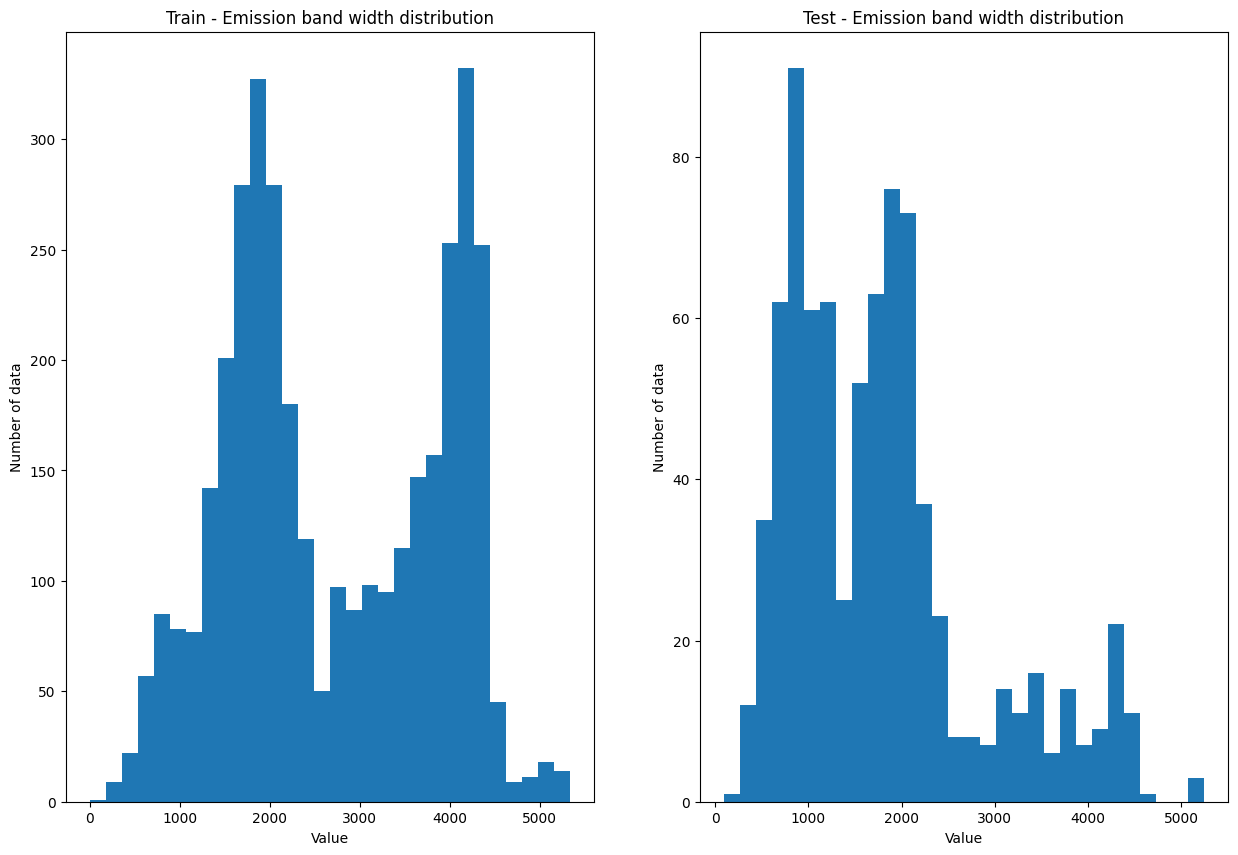

In [36]:
cols = math.ceil(math.sqrt(2))  # Try to make the figure roughly square
rows = math.ceil(2 / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array for easy iteration (only if more than 1 row/column)
axes = axes.flatten()

train_emission_band_widths = [data.delta_f for data in train_database.datas]
axes[0].hist(train_emission_band_widths, bins = 30)
axes[0].set_title(f'Train - Emission band width distribution')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Number of data')

test_emission_band_widths = [data.delta_f for data in test_database.datas]
axes[1].hist(test_emission_band_widths, bins = 30)
axes[1].set_title(f'Test - Emission band width distribution')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Number of data')


plt.show()



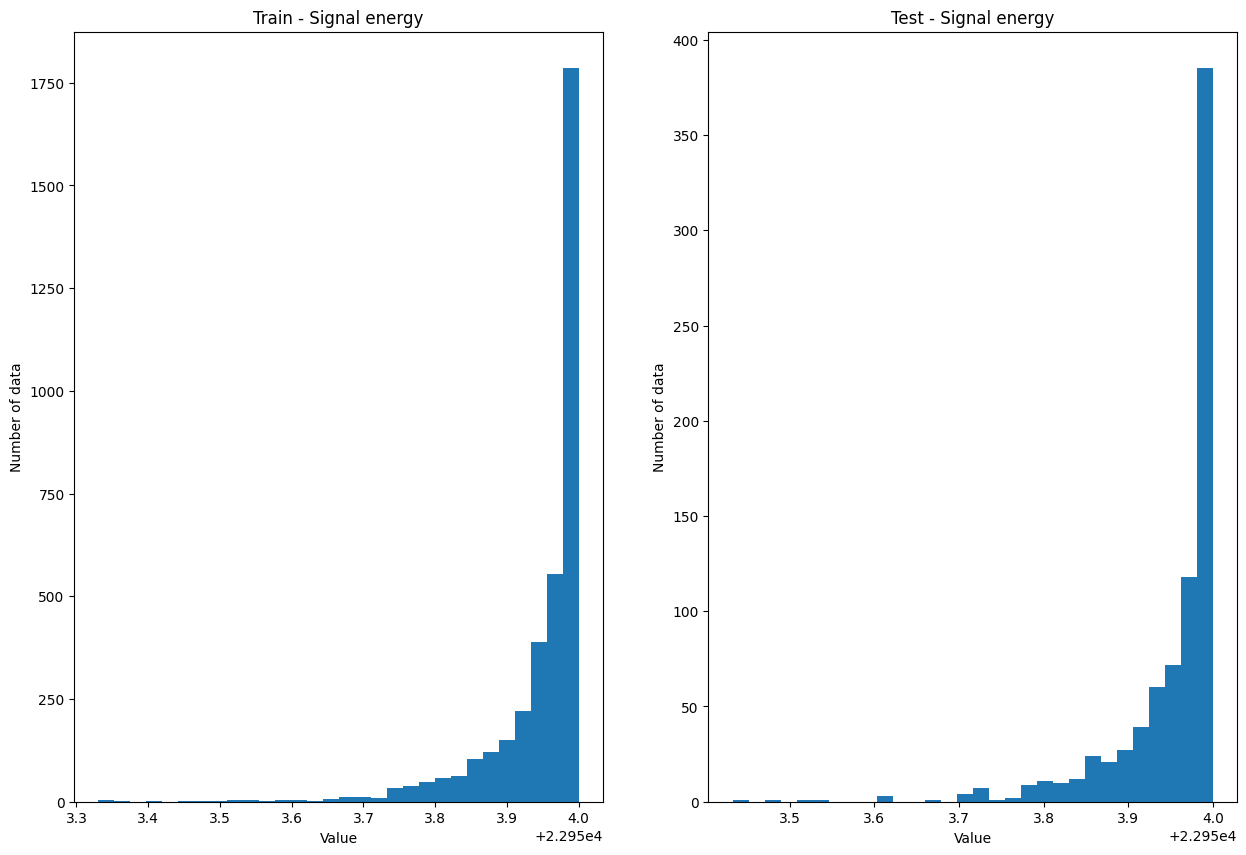

In [37]:
cols = math.ceil(math.sqrt(2))  # Try to make the figure roughly square
rows = math.ceil(2 / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array for easy iteration (only if more than 1 row/column)
axes = axes.flatten()

train_emission_band_widths = [data.energy for data in train_database.datas]
axes[0].hist(train_emission_band_widths, bins = 30)
axes[0].set_title(f'Train - Signal energy')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Number of data')

test_emission_band_widths = [data.energy for data in test_database.datas]
axes[1].hist(test_emission_band_widths, bins = 30)
axes[1].set_title(f'Test - Signal energy')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Number of data')


plt.show()

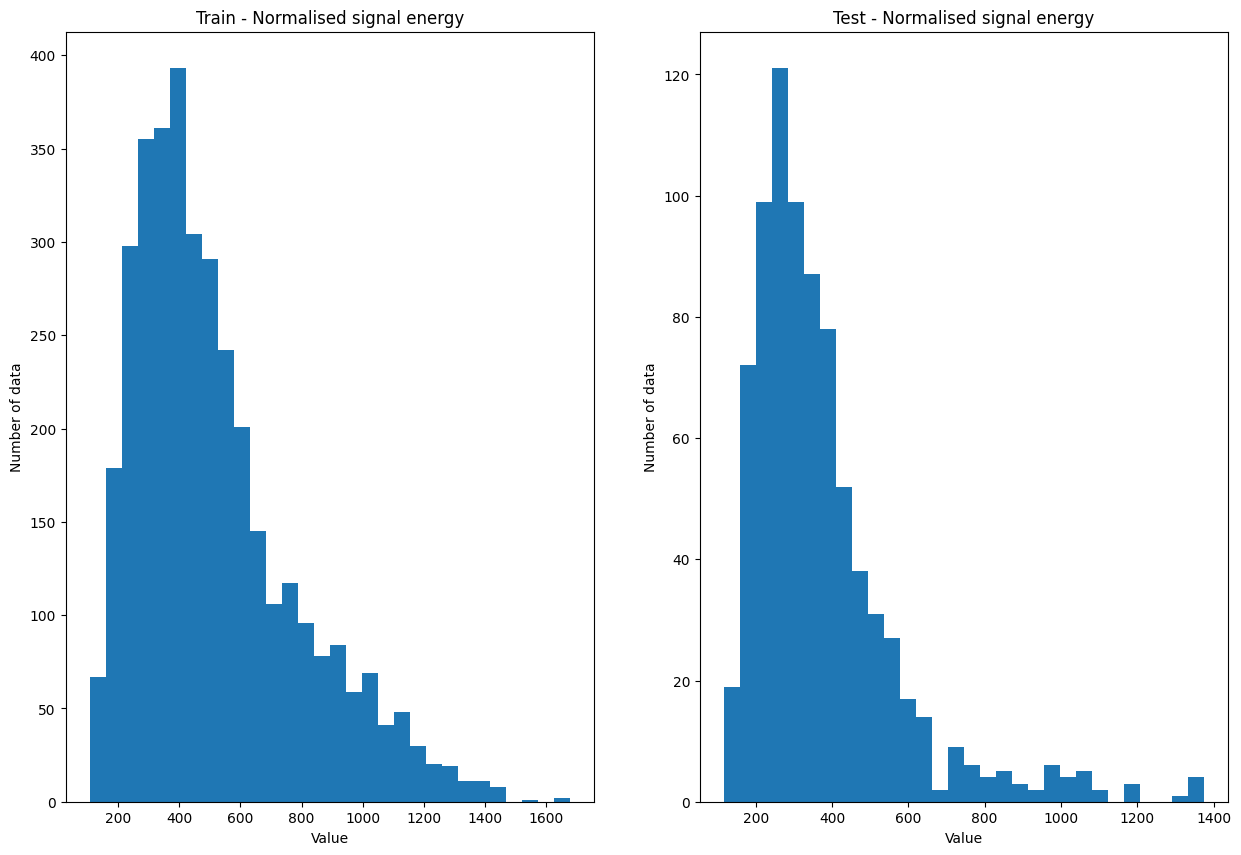

In [38]:
cols = math.ceil(math.sqrt(2))  # Try to make the figure roughly square
rows = math.ceil(2 / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array for easy iteration (only if more than 1 row/column)
axes = axes.flatten()

train_emission_band_widths = [data.normalised_energy for data in train_database.datas]
axes[0].hist(train_emission_band_widths, bins = 30)
axes[0].set_title(f'Train - Normalised signal energy')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Number of data')

test_emission_band_widths = [data.normalised_energy for data in test_database.datas]
axes[1].hist(test_emission_band_widths, bins = 30)
axes[1].set_title(f'Test - Normalised signal energy')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Number of data')


plt.show()